<a href="https://colab.research.google.com/github/lhayana/flight-price-prediction/blob/main/Flight_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fonte dos dados: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

# Importando os dados e as bibliotecas

In [70]:
# pip install category_encoders

In [71]:
# pip install catboost

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, make_scorer

In [73]:
!wget https://raw.githubusercontent.com/lhayana/flight-price-prediction/refs/heads/main/data/Clean_Dataset.csv

--2024-10-24 14:24:29--  https://raw.githubusercontent.com/lhayana/flight-price-prediction/refs/heads/main/data/Clean_Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24683279 (24M) [text/plain]
Saving to: ‘Clean_Dataset.csv.5’

Clean_Dataset.csv.5 100%[===================>]  23.54M  --.-KB/s    in 0.09s   

2024-10-24 14:24:30 (275 MB/s) - ‘Clean_Dataset.csv.5’ saved [24683279/24683279]



In [74]:
data = pd.read_csv('Clean_Dataset.csv', index_col=0)

In [75]:
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [76]:
data['route'] = data['source_city'] + ' - ' + data['destination_city']

# Análise exploratória

In [77]:
sns.set(style="whitegrid")

<ipython-input-78-09caffa5c07a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='airline', data=data, order=airline_order, palette='hls')


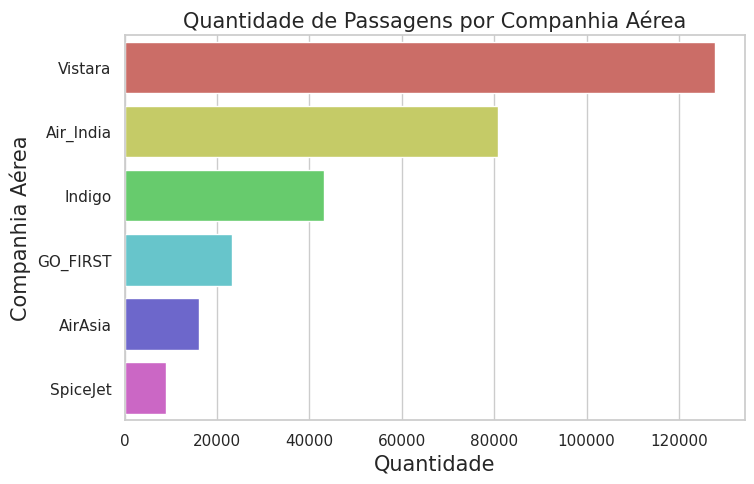

In [78]:
plt.figure(figsize=(8,5))
airline_order = data['airline'].value_counts().index
sns.countplot(y='airline', data=data, order=airline_order, palette='hls')
plt.title('Quantidade de Passagens por Companhia Aérea', fontsize=15)
plt.xlabel('Quantidade', fontsize=15)
plt.ylabel('Companhia Aérea', fontsize=15)
plt.show()

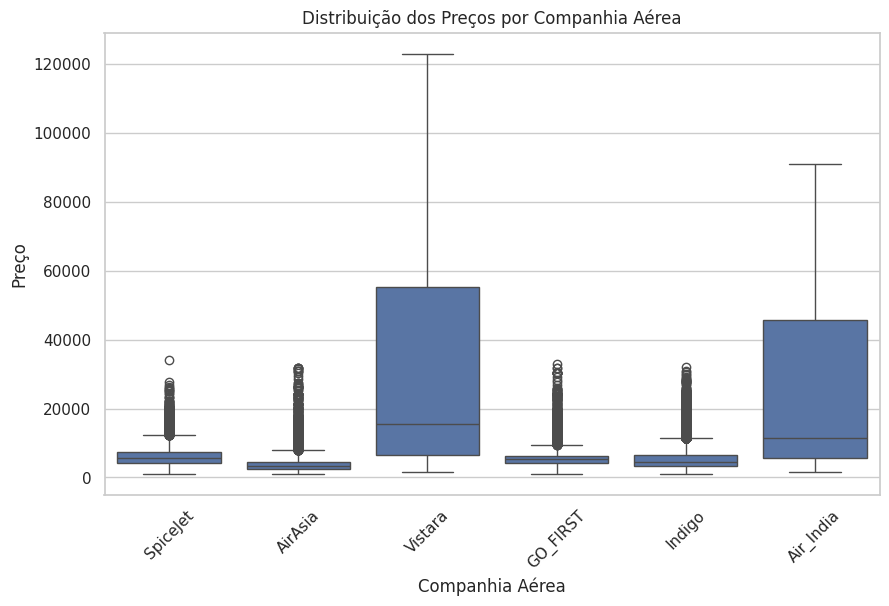

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='airline', y='price', data=data)
plt.title('Distribuição dos Preços por Companhia Aérea')
plt.xlabel('Companhia Aérea')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

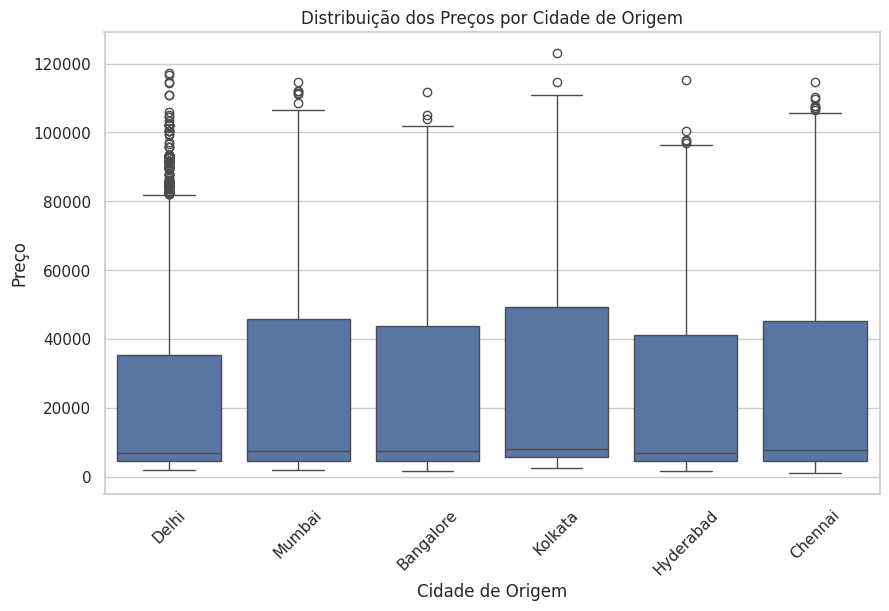

In [80]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='source_city', y='price', data=data)
plt.title('Distribuição dos Preços por Cidade de Origem')
plt.xlabel('Cidade de Origem')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

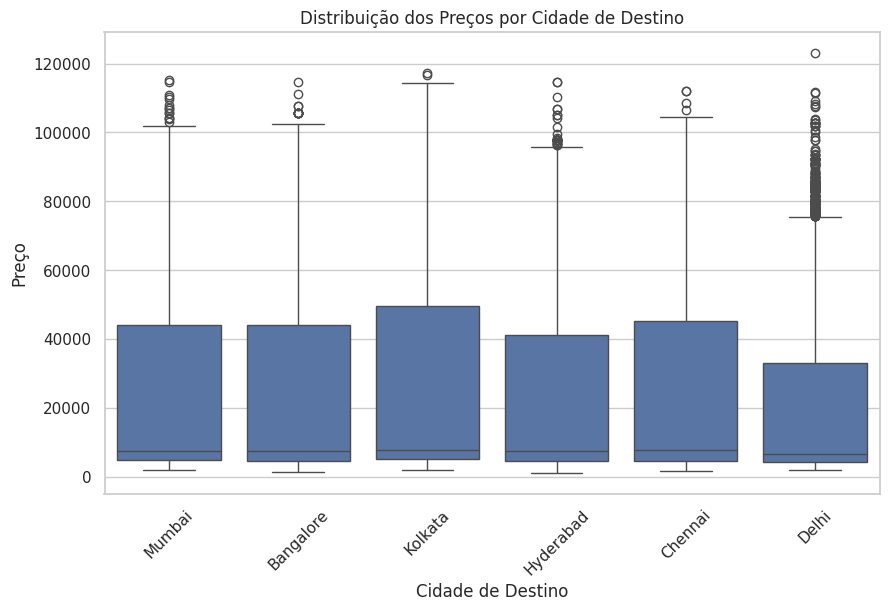

In [81]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='destination_city', y='price', data=data)
plt.title('Distribuição dos Preços por Cidade de Destino')
plt.xlabel('Cidade de Destino')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

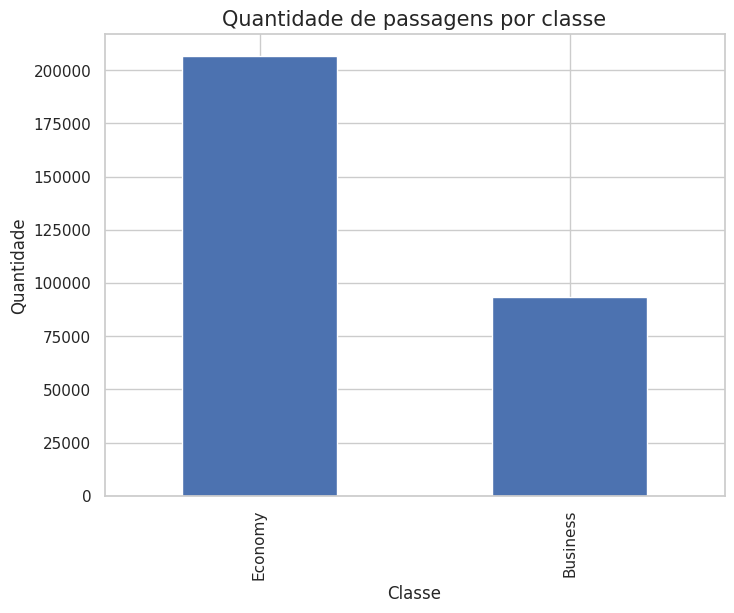

In [82]:
plt.figure(figsize=(8,6))
class_counts = data['class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Quantidade de passagens por classe', fontsize=15)
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(ticks=range(len(class_counts)), labels=class_counts.index)
plt.show()

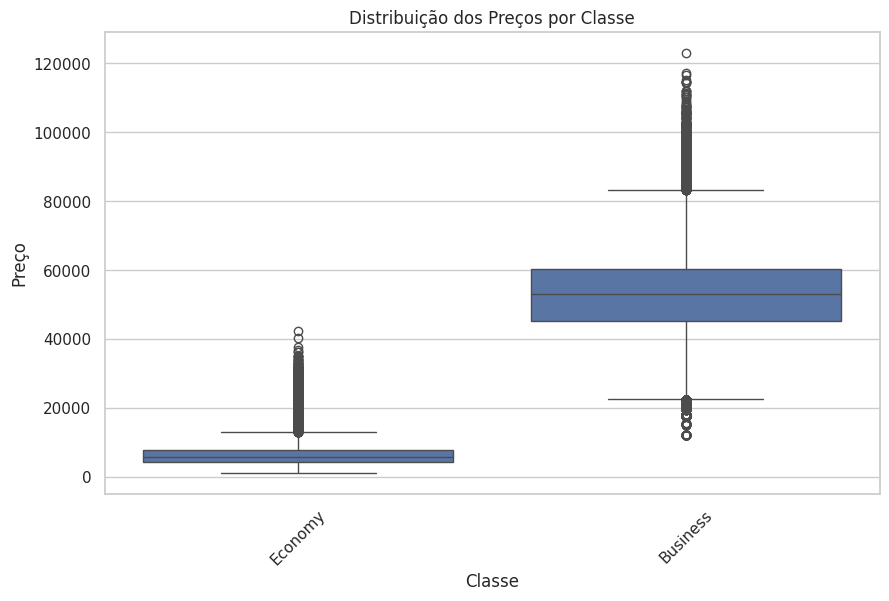

In [83]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='price', data=data)
plt.title('Distribuição dos Preços por Classe')
plt.xlabel('Classe')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

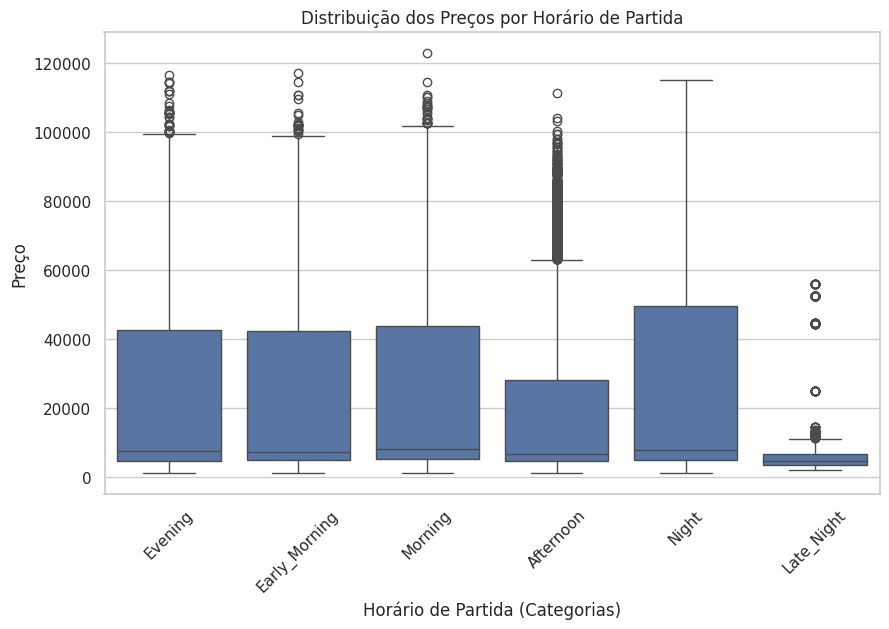

In [84]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='departure_time', y='price', data=data)
plt.title('Distribuição dos Preços por Horário de Partida')
plt.xlabel('Horário de Partida (Categorias)')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

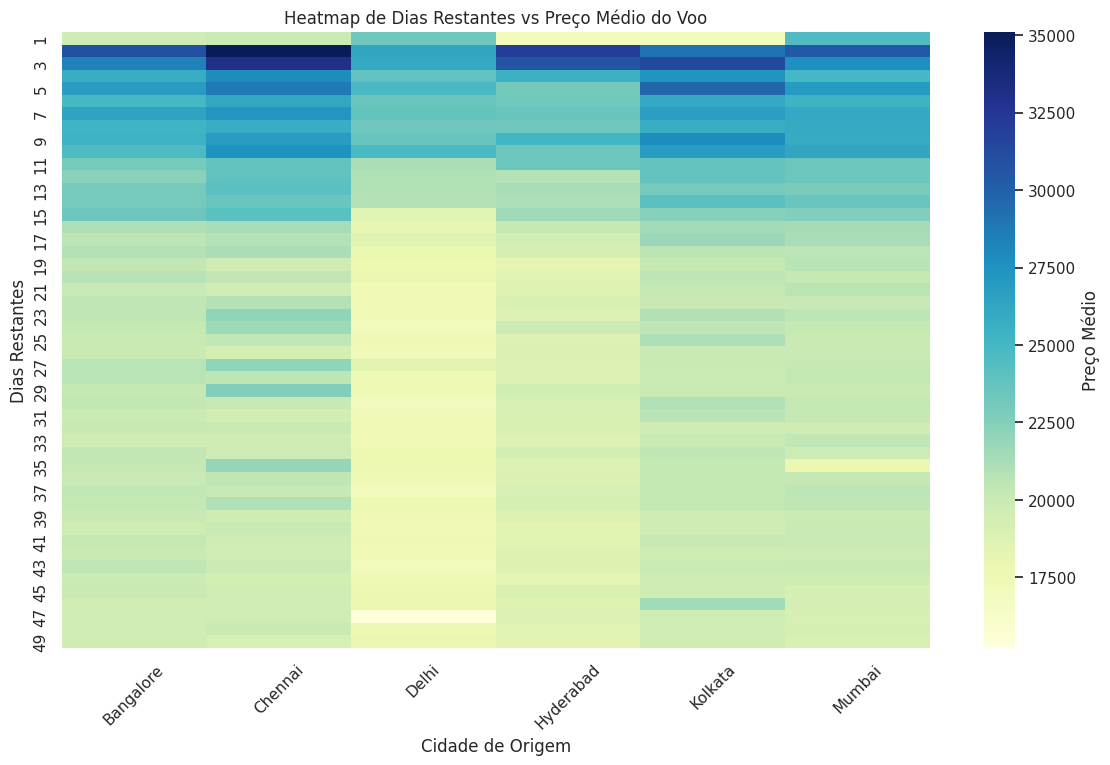

In [85]:
heatmap_dias = pd.pivot_table(data, values='price', index='days_left', columns='source_city', aggfunc='mean')

# Plotando o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_dias, cmap='YlGnBu', cbar_kws={'label': 'Preço Médio'})
plt.title('Heatmap de Dias Restantes vs Preço Médio do Voo')
plt.xlabel('Cidade de Origem')
plt.ylabel('Dias Restantes')
plt.xticks(rotation=45)
plt.show()

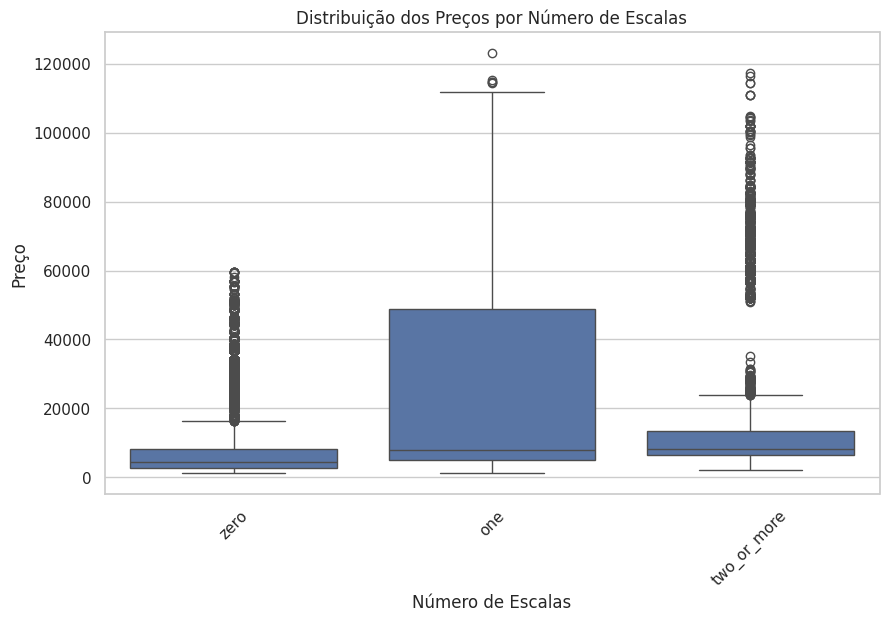

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='stops', y='price', data=data)
plt.title('Distribuição dos Preços por Número de Escalas')
plt.xlabel('Número de Escalas')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.show()

<ipython-input-87-c70b2a1ee147>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='departure_time', y='price', data=data, palette='hls', order=time_order)
<ipython-input-87-c70b2a1ee147>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='arrival_time', y='price', data=data, palette='hls', order=time_order)


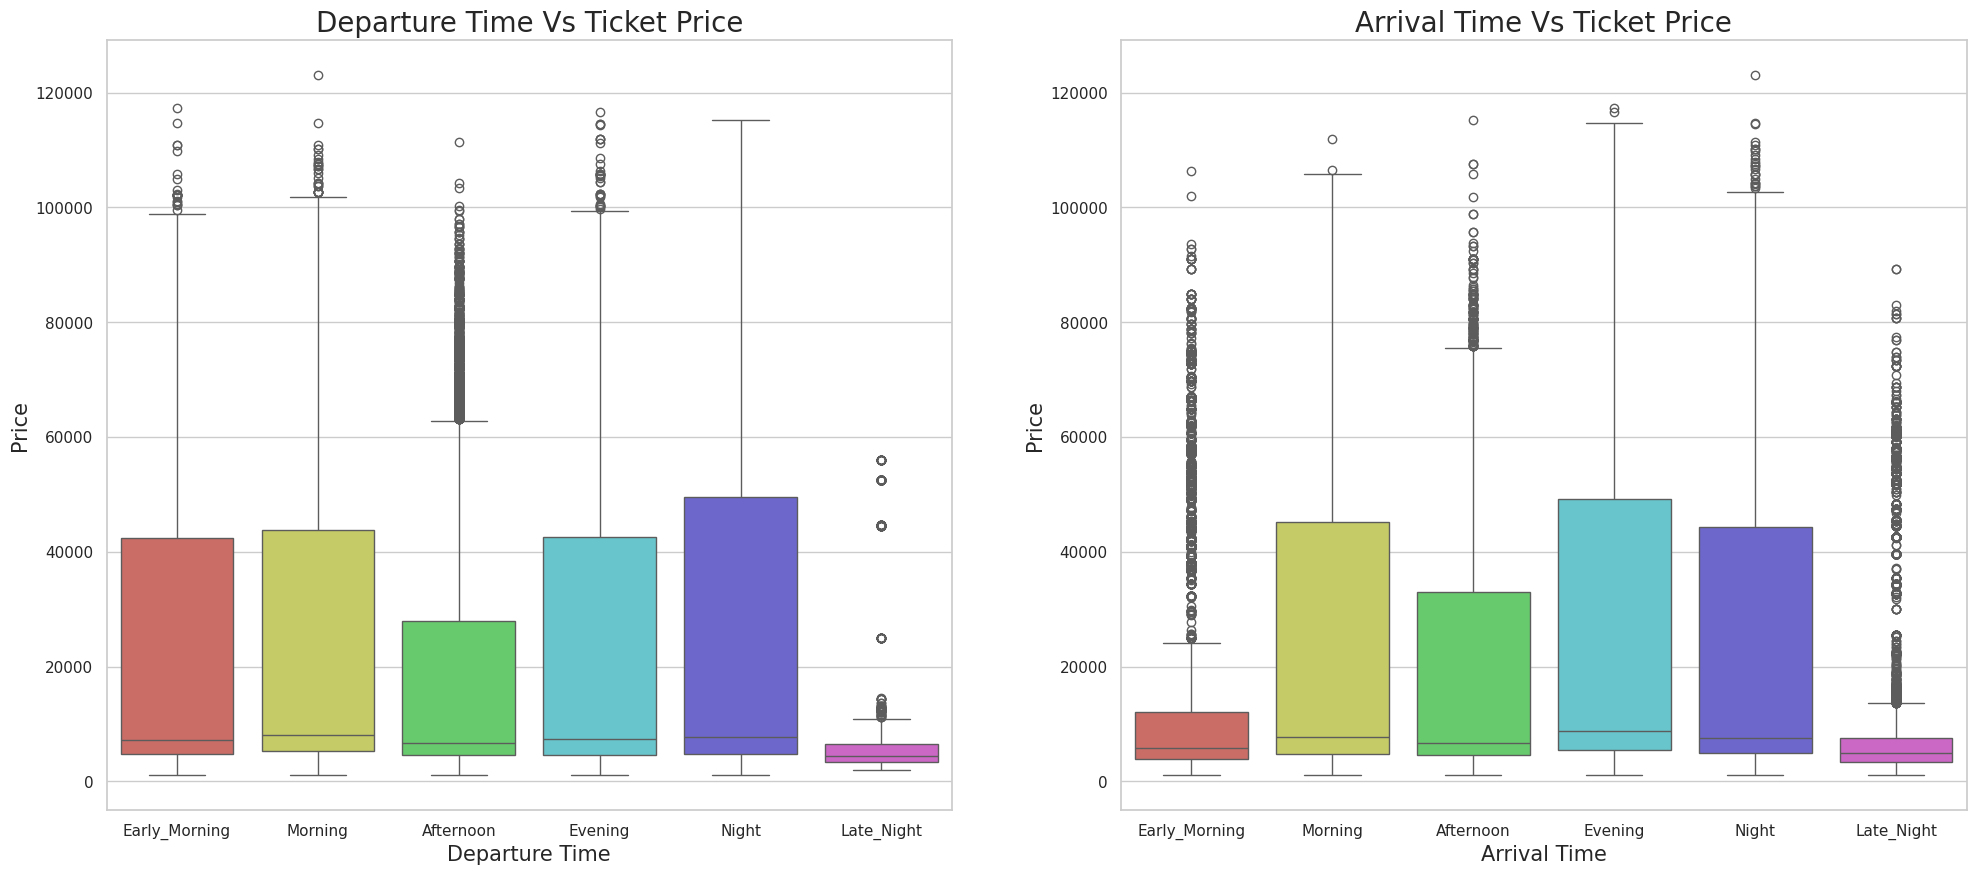

In [87]:
time_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night']

plt.figure(figsize=(24,10))

plt.subplot(1,2,1)
sns.boxplot(x='departure_time', y='price', data=data, palette='hls', order=time_order)
plt.title('Departure Time Vs Ticket Price', fontsize=20)
plt.xlabel('Departure Time', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.subplot(1,2,2)
sns.boxplot(x='arrival_time', y='price', data=data, palette='hls', order=time_order)
plt.title('Arrival Time Vs Ticket Price', fontsize=20)
plt.xlabel('Arrival Time', fontsize=15)
plt.ylabel('Price', fontsize=15)

plt.show()

In [88]:
data.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price', 'route'],
      dtype='object')

# Modelagem

In [90]:
numerical_features= ['duration','days_left']

categorical_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'route']

In [91]:
features = ['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left', 'route']

target = 'price'

In [92]:
X = data[features]
y = data[target]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [94]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder", TargetEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ("cat", categorical_transformer, categorical_features)
])

#### Testando diversos modelos

In [95]:
xgb = XGBRegressor()

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',xgb)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder())]),
                                                  ['airline', 'flight',
                                                   'source_city',
                                                   'departure_time', 'stops',
                                                   'arrival_time',
                                                   'destination_city', 'class',
                                                   'route'])])),
                ('model',
                 XGBRegressor(base_score=None, bo...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [96]:
y_pred = pipe.predict(X_test)

In [97]:
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")

MAE: 1615.385654497821
MSE: 8552568.94190979
RMSE: 2924.477550248897


In [98]:
y_test.mean()

20894.0129099965

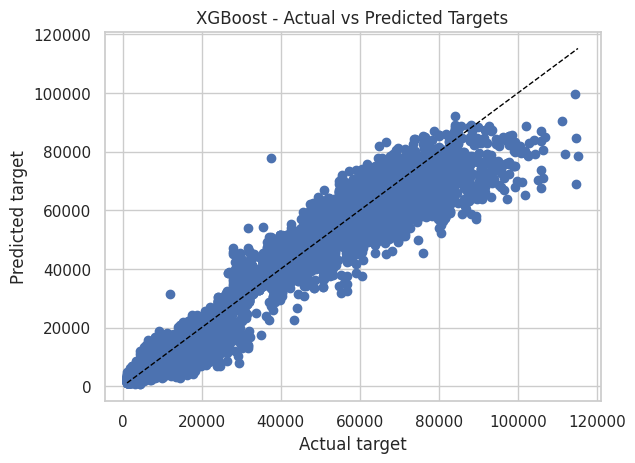

In [99]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('XGBoost - Actual vs Predicted Targets')
plt.show()

In [100]:
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores

array([-8111611.79630739, -8311557.76881704, -8205661.4689555 ,
       -8483479.75341428, -8489839.95862723])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 240122, number of used features: 11
[LightGBM] [Info] Start training from score 20888.572417
MAE: 1890.6029740360377
MSE: 10718881.901589736
RMSE: 3273.9703574696177


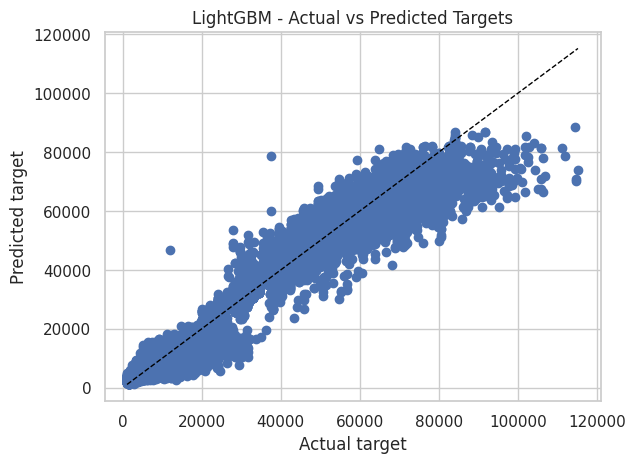

In [101]:
# LightGBM

from lightgbm import LGBMRegressor
lgb = LGBMRegressor()
pipe_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb)
])
pipe_lgb.fit(X_train, y_train)

y_pred = pipe_lgb.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('LightGBM - Actual vs Predicted Targets')
plt.show()

MAE: 1623.337259388564
MSE: 8726052.270535504
RMSE: 2953.9892130025637


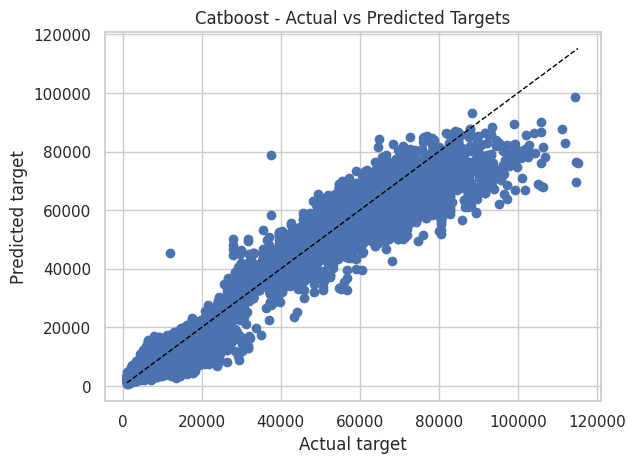

In [102]:
# Catboost

cat = CatBoostRegressor(silent=True)
pipe_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', cat)
])
pipe_cat.fit(X_train, y_train)

y_pred = pipe_cat.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('Catboost - Actual vs Predicted Targets')
plt.show()

MAE: 4614.178552971513
MSE: 48471936.80607994
RMSE: 6962.17902714947


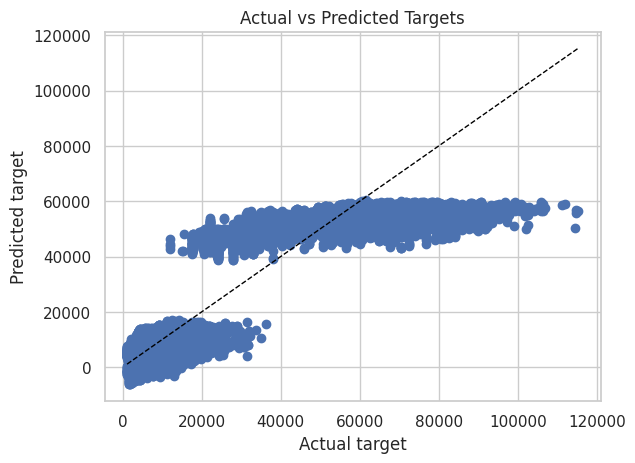

In [103]:
# Regressão Ridge

from sklearn.linear_model import Ridge
ridge = Ridge()
pipe_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ridge)
])
pipe_ridge.fit(X_train, y_train)

y_pred = pipe_ridge.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5}")

y_test.mean()

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='black', linewidth=1)
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.title('Actual vs Predicted Targets')
plt.show()

#### Resultados com cross-validation

In [104]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse)

def evaluate_model(pipe, X, y):
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring=rmse_scorer)
    return cv_scores.mean(), cv_scores.std()

results = {}

# XGBoost
results['XGBoost'] = evaluate_model(pipe, X_train, y_train)

# LightGBM
results['LightGBM'] = evaluate_model(pipe_lgb, X_train, y_train)

# CatBoost
results['CatBoost'] = evaluate_model(pipe_cat, X_train, y_train)

# Ridge
results['Ridge'] = evaluate_model(pipe_ridge, X_train, y_train)

results_df = pd.DataFrame(results, index=['Mean RMSE', 'Std RMSE']).T
print("\nResultados dos Modelos:")
print(results_df)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 192097, number of used features: 11
[LightGBM] [Info] Start training from score 20892.155041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 192097, number of used features: 11
[LightGBM] [Info] Start training from score 20873.140413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 